# HMM-mMLDA

In [1]:
%matplotlib inline
%pylab inline
from operator import mul, add
from functools import reduce
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import json
warnings.filterwarnings('ignore')
import time
from pomegranate import *
import pomegranate
import holoviews as hv
from IPython import  display
import pickle
hv.extension('matplotlib')
# hv.extension('bokeh')
pomegranate.utils.disable_gpu()

Populating the interactive namespace from numpy and matplotlib


### learnmodelから全モダリティ観測時のtop_thetaを集める

In [13]:
all_theta = np.loadtxt("/home/robocup/Desktop/mmlda_bhmm/module049_mlda/Pdz.txt")

In [14]:
action_num_lists = np.loadtxt("/home/robocup/Desktop/miyazawa_crest_2018/caption/action_nums.txt",dtype=np.int32)

In [15]:
seqs = []
front = None
back = None
for i in range(len(action_num_lists)):
    tmp = all_theta[sum(action_num_lists[:i]):sum(action_num_lists[:i+1])]
    seqs.append(tmp)

In [16]:
n_components = 12

### 多項分布 [N=100,S=32,w_dim=32]

In [17]:
%%time
multi_n = 100
# seqsの各Zのサンプリング N=100
multi_sample_seqs = []
for seq in seqs:
    multi_sample_seq = []
    for s in seq:
        initial_value = {'dim'+str(i):prob for i,prob in enumerate(s)}
        tmp_discrite = DiscreteDistribution(initial_value)
        tmp_independent = IndependentComponentsDistribution([tmp_discrite for i in  range(multi_n)])
        while (True):
            sample = tmp_independent.sample(1)[0].tolist()
            if sum(isin(sample,None)) == 0:
                break
        multi_sample_seq.append(sample)
    multi_sample_seqs.append(multi_sample_seq)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.45 ms


In [18]:
transmat = np.abs(np.random.randn(n_components, n_components))
transmat = (transmat.T / transmat.sum( axis=1 )).T
start_probs = np.abs( np.random.randn(n_components) )
start_probs /= start_probs.sum()
initial_value = {'dim'+str(i):1.0 / n_components for i in range(n_components)}
states = []
for s in range(n_components):
    tmp_discrite = DiscreteDistribution(initial_value)
    tmp_independent = IndependentComponentsDistribution([tmp_discrite for i in  range(multi_n)])
    states.append(tmp_independent)
model = HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge='None')

In [19]:
%%time
model.fit(multi_sample_seqs, verbose=True, n_jobs=8, algorithm = "baum-welch")

[1] Improvement: nan	Time (s): 0.01769
Total Training Improvement: nan
Total Training Time (s): 0.1042
CPU times: user 40 ms, sys: 44 ms, total: 84 ms
Wall time: 104 ms


nan

hmm theta

In [20]:
theta = []
for m in range(n_components):
    param = model.states[m].distribution.distributions[0].parameters[0]
    tmp_theta = [param['dim'+str(i)] for i in range(len(param))]
    theta.append(tmp_theta)

* 物体の予測系列

In [13]:
def calc_object_prob(states_predict):
    alpha = 0.1
    recogModel_dir = "/home/robocup/Desktop/miyazawa_crest_2018/mmlda_single/module004_mlda/Pmdw[0].txt"
    Nwz  = np.loadtxt(recogModel_dir)

    object_prob_series = []     
    W, Z = Nwz.shape
    Pwz  = np.zeros( (W, Z) )
    for w in range( W ):
        for z in range( Z ):
            Pwz[ w, z ] = float( Nwz[w, z] + alpha ) / ( np.sum( Nwz[:, z] ) + W * alpha )
    pwz_df = pd.DataFrame(Pwz)
    object_prob_each_Z = pwz_df.dot(pd.DataFrame(theta).T)

    for tmp_state in states_predict:
        tmp = []
        for i in range(len(tmp_state)):
            probs_i = object_prob_each_Z[tmp_state[i]]
            tmp.append(list(probs_i))
        object_prob_series.append(tmp)
    return object_prob_series

In [23]:
len(calc_object_prob([[1,2,0],[0,0,2]])[0][0])

150

In [186]:
tmp_logp, tmp_path = model.viterbi([start_state,nan_list,nan_list,end_state])

In [188]:
start_state = model.states[2].distribution.sample(1)[0]
end_state = model.states[3].distribution.sample(1)[0]

In [189]:
tmp_logp, tmp_path = model.viterbi([nan_list,nan_list,nan_list,nan_list,nan_list,nan_list])

In [190]:
tmp = tmp_path[2]

In [191]:
get_theta_from_dist(tmp[1].distribution)

[0.008676470588235277,
 0.5300000000000025,
 0.010147058823529242,
 0.4511764705882298]

In [ ]:
def states2w(hmm_states):
    """
    hmmの系列から，下位の概念と観測情報を出力する    
    
    """
    
    

In [ ]:
model.states[m].distribution.distributions[0].parameters[0]

In [50]:
import sys
sys.path.append("/home/robocup/Desktop/crest/.")
from mlda import mlda as mlda_p

In [132]:
top_n_mwz, tmp = mlda_p.load_model("/home/robocup/Desktop/miyazawa_crest_2018/ML_BHMM_miya/module034_mlda/")
motion_n_mwz, tmp = mlda_p.load_model("/home/robocup/Desktop/miyazawa_crest_2018/ML_BHMM_miya/module033_mlda/")
object_n_mwz, tmp = mlda_p.load_model("/home/robocup/Desktop/miyazawa_crest_2018/ML_BHMM_miya/module032_mlda/")

In [133]:
a = np.array( np.matrix(top_n_mwz[0]) * np.matrix(object_n_mwz[1]) )
b = np.array( np.matrix(top_n_mwz[0]) * np.matrix(motion_n_mwz[1]) )

In [134]:
for i in range(4):
    print wordlist[a[i].argsort()[-1]]

箱
を
ペットボトル
ペットボトル


In [135]:
for i in range(4):
    try:
        print wordlist[b[i].argsort()[-1]]
    except:
        print None

None
ペットボトル
を
を


In [84]:
word_list_df = pd.read_csv('/home/robocup/Desktop/miyazawa_crest_2018/ML_BHMM_miya/LearnData/wordlist.txt',header=-1)
# word_list_df.columns = ["word"]

wordlist = []
for i in range(len(word_list_df)):
    wordlist.append(word_list_df.iloc[i][0])
wordlist.append("BOS")
wordlist.append("EOS")

In [136]:
b = np.array( np.matrix(top_n_mwz[0]) * np.matrix(motion_n_mwz[0]) )

In [38]:
nan_list = [nan for i in range(multi_n)]

In [19]:
len(multi_sample_seqs[0])

9

In [ ]:
get_theta_from_dist()

In [172]:
def get_theta_from_dist(distribution):
    """
    多項分布のpomegranateの分布のパラメータを取得する
    
    return: theta
    """
    param = model.states[m].distribution.distributions[0].parameters[0]
    theta = [param['dim'+str(i)] for i in range(len(param))]
    return theta

In [149]:
def calc_prob(Nwz):
    """
    NwzからPwzを計算
    """
    alpha = 0.1
    W, Z = Nwz.shape
    Pwz  = np.zeros( (W, Z) )
    for w in range( W ):
        for z in range( Z ):
            Pwz[ w, z ] = float( Nwz[w, z] + alpha ) / ( np.sum( Nwz[:, z] ) + W * alpha )
    return pd.DataFrame(Pwz)

In [155]:
top_pwz = calc_prob(top_n_mwz[0])

In [156]:
object_pwz = calc_prob(object_n_mwz[1])

In [158]:
obj = object_pwz.dot(top_pwz)

ValueError: matrices are not aligned

In [159]:
obj = top_pwz.dot(object_pwz)

In [160]:
obj

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.999655,0.999655,0.998788,0.998832,0.998927,0.000194,0.000151,0.000663,0.000663,0.000773,...,0.312505,0.312505,0.312505,0.312505,0.312505,0.312505,0.312505,0.312505,0.312505,0.312505
1,0.000145,0.000145,0.000540,0.000520,0.000476,0.000194,0.353536,0.000663,0.000663,0.000773,...,0.312464,0.312464,0.312464,0.312464,0.312464,0.312464,0.312464,0.312464,0.312464,0.312464
2,0.000097,0.000097,0.000325,0.000313,0.000288,0.471912,0.305123,0.471474,0.471474,0.471372,...,0.180540,0.180540,0.180540,0.180540,0.180540,0.180540,0.180540,0.180540,0.180540,0.180540
3,0.000102,0.000102,0.000348,0.000335,0.000308,0.527700,0.341190,0.527200,0.527200,0.527083,...,0.194492,0.194492,0.194492,0.194492,0.194492,0.194492,0.194492,0.194492,0.194492,0.194492


In [162]:
model.viterbi([nan_list,nan_list,nan_list])

-1.3241214429233321

* 行動の予測系列

In [ ]:
def calc_action_prob(states_predict):
    alpha = 0.1
    recogModel_dir = "/home/miyazawa/tmp_cognitive_maze_dir/20171227_213206/analysis/mmlda/recogModels_with_all/episode{0:04d}/recogModel".format(EPISODE)
    Nwz  = np.loadtxt(os.path.join(recogModel_dir,"model/001/Nmwy000.txt"))

    action_prob_series = []     
    W, Z = Nwz.shape
    Pwz  = np.zeros( (W, Z) )
    for w in range( W ):
        for z in range( Z ):
            Pwz[ w, z ] = float( Nwz[w, z] + alpha ) / ( np.sum( Nwz[:, z] ) + W * alpha )
    pwz_df = pd.DataFrame(Pwz)
    action_prob_each_Z = pwz_df.dot(pd.DataFrame(theta).T)

    for tmp_state in states_predict:
        tmp = []
        for i in range(len(tmp_state)):
            probs_i = action_prob_each_Z[tmp_state[i]]
            tmp.append(list(probs_i))
        action_prob_series.append(tmp)
    return action_prob_series

* 報酬の予測系列

In [ ]:
def calc_reward_prob(states_predict):
    alpha = 0.1
    recogModel_dir = "/home/miyazawa/tmp_cognitive_maze_dir/20171227_213206/analysis/mmlda/recogModels_with_all/episode{0:04d}/recogModel".format(EPISODE)
    Nwz  = np.loadtxt(os.path.join(recogModel_dir,"model/002/Nmwy000.txt"))

    reward_prob_series = []
    W, Z = Nwz.shape
    Pwz  = np.zeros( (W, Z) )
    for w in range( W ):
        for z in range( Z ):
            Pwz[ w, z ] = float( Nwz[w, z] + alpha ) / ( np.sum( Nwz[:, z] ) + W * alpha )
    pwz_df = pd.DataFrame(Pwz)
    reward_prob_each_Z = pwz_df.dot(pd.DataFrame(theta).T)

    for tmp_state in states_predict:
        tmp = []
        for i in range(len(tmp_state)):
            probs_i = reward_prob_each_Z[tmp_state[i]]
            tmp.append(list(probs_i))
        reward_prob_series.append(tmp)
    return reward_prob_series

thetaからサンプリング

In [38]:
def sampling_multi(theta):
    initial_value = {'dim'+str(i):prob for i,prob in enumerate(theta)}
    tmp_discrite = DiscreteDistribution(initial_value)
    tmp_independent = IndependentComponentsDistribution([tmp_discrite for i in  range(multi_n)])
    while (True):
        sample = tmp_independent.sample(1)[0].tolist()
        if sum(isin(sample,None)) == 0:
            break
    return sample

n系列のビタビ計算

In [39]:
nan = np.nan
nan_list = [nan for i in range(multi_n)]
NAN = [nan_list for i in range(20)] #maxの遷移回数
def get_statesequence_pom(x_s, x_g, min_num_trans, max_num_trans,model):
    logp = -np.inf
    path = None
    for num in range(min_num_trans,max_num_trans+1):
        tmp_seq = [x_s] + [nan_list for i in range(num-1)] + [x_g]
#         tmp_seq = [x_s] + NAN[:num-1] + [x_g]
        tmp_logp, tmp_path = model.viterbi(tmp_seq)
        if logp < tmp_logp:
            logp = tmp_logp
            path = tmp_path
    path = np.array(path)[:,0][1:].tolist()
    return logp, path

系列長の選択を予測報酬の合計値で行う

In [ ]:
nan = np.nan
nan_list = [nan for i in range(multi_n)]
NAN = [nan_list for i in range(20)] #maxの遷移回数
def get_statesequence_pom_reward(x_s, x_g, min_num_trans, max_num_trans,model):
    logp = -np.inf
    path = None
    sum_reward = -np.inf
    for num in range(min_num_trans,max_num_trans+1):
        tmp_seq = [x_s] + [nan_list for i in range(num-1)] + [x_g]
#         tmp_seq = [x_s] + NAN[:num-1] + [x_g]
        tmp_logp, tmp_path = model.viterbi(tmp_seq)
        tmp_path = np.array(tmp_path)[:,0][1:].tolist()
        sum_reward_tmp = np.dot(calc_reward_prob([tmp_path])[0],[-1,0,1]).sum()
        if sum_reward < sum_reward_tmp:
            logp = tmp_logp
            path = tmp_path
            sum_reward = sum_reward_tmp
    return logp, path

### 報酬合計が最大のパスを選択

In [ ]:
joe_correct_category = pd.read_csv("/home/miyazawa/catkin_ws/src/action_learning/src/action_learning/joe_data/all_correct_category.csv")
joe_correct_category = joe_correct_category.sort_values(by=["category","object_id"]).drop("name",axis=1)
joe_correct_category = joe_correct_category[joe_correct_category.category < category_num]
tmp_df_list = []
for a in range(4):# add action label
    joe_correct_category["action"] = a
    tmp_df_list.append(joe_correct_category.copy())
joe_correct_category = pd.concat(tmp_df_list)
joe_correct_category.index =  range(joe_correct_category.shape[0])

all_object_theta = np.loadtxt(theta_file)
all_object_theta_df = pd.DataFrame(all_object_theta)
all_object_theta_df.columns = recog_theta_all_top

test_data_xs = pd.concat([joe_correct_category,all_object_theta_df],axis=1)

In [ ]:
results_list = []
tic = time.time()
for x_s in test_data_xs[recog_theta_all_top].values:
    states_predict = []
    x_s = sampling_multi(x_s)
    for j in range(32):
        x_g = model.states[j].distribution.sample(1)[0]
        tmp_logp, tmp_path = get_statesequence_pom_reward(x_s,x_g,1,10, model)
        states_predict.append(tmp_path)
#     states_predict = output
    action_prob_series = calc_action_prob(states_predict)
    reward_prob_series = calc_reward_prob(states_predict)
    results_list.append((states_predict, action_prob_series, reward_prob_series))
print time.time() - tic

In [ ]:
model.predict_proba([sampling_multi(1)])[0]

各thetaに対する出力確率

In [40]:
d_prob_max= []
for scene in all_object_theta_df.values:
    tmp_list = []
    for i in range(4):
        sample = sampling_multi(scene)
        tmp_list.append(model.states[i].distribution.probability([sample]))
    d_prob_max.append(argmax(tmp_list))
tmp_df = pd.DataFrame(d_prob_max)
tmp_df['count'] =0
tmp_df.groupby(0).count().T

NameError: name 'all_object_theta_df' is not defined

系列推定としての確率値

In [41]:
path_prob_max= []
for scene in all_object_theta_df.values:
    arg_max =  argmax(model.predict_proba([sampling_multi(scene)]))
#     print arg_max, model.predict_proba([sampling_multi(scene)])[0][arg_max]
    path_prob_max.append(arg_max)
tmp_df = pd.DataFrame(path_prob_max)
tmp_df['count'] =0
tmp_df.groupby(0).count().T

NameError: name 'all_object_theta_df' is not defined

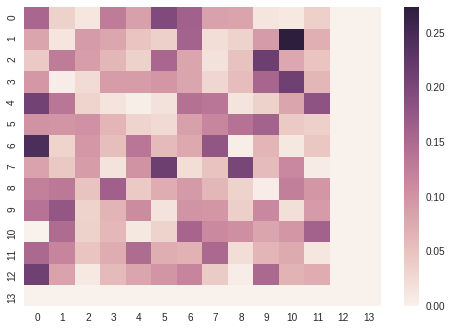

In [21]:
trans_mat = model.dense_transition_matrix()
sns.heatmap(trans_mat)

In [ ]:
action_prob_series = calc_action_prob(states_predict)
reward_prob_series = calc_reward_prob(states_predict)

## P(wr | Z by hsmm ) P(wm | Z by hsmm )の可視化

### thetaとaction hmm

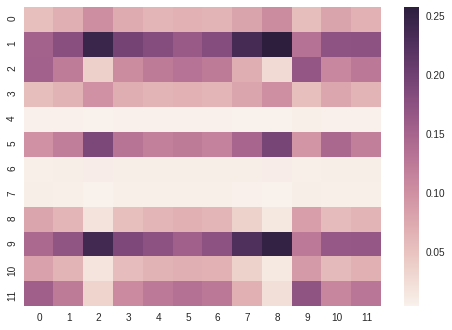

In [22]:
sns.heatmap(pd.DataFrame(theta).T)

In [ ]:
action_prob_series = calc_action_prob(states_predict)
reward_prob_series = calc_reward_prob(states_predict)

In [ ]:
%%output size=100
%%opts HeatMap [width=600 height=200 tools=['hover'] fontsize={'xticks': '10pt'} colorbar_opts={'width':10} colorbar=True] (cmap='Blues')
data = [(j,i,action_prob_each_Z.values[i,j]) for i in range(action_prob_each_Z.shape[0]) for j in range(action_prob_each_Z.shape[1])]
hv.HeatMap(data, label="action prob each S from hmm").hist()

In [ ]:
%%output size=100
%%opts HeatMap [width=600 height=200 tools=['hover'] fontsize={'xticks': '10pt'} colorbar_opts={'width':10} colorbar=True] (cmap='Blues')
data = [(j,i,reward_prob_each_Z.values[i,j]) for i in range(reward_prob_each_Z.shape[0]) for j in range(reward_prob_each_Z.shape[1])]
hv.HeatMap(data, label="reward prob each S from hmm").hist()

In [ ]:
%%opts Histogram [tools=['hover']]
arg_max_data = [argmax(list(all_object_theta_tmp.iloc[s])) for s in range(134*4)]
data = [arg_max_data.count(i) for i in range(32)]
hv.Histogram(data)

In [ ]:
%%opts Histogram [tools=['hover']]
hv.Histogram([labels.count(i) for i in range(32)])

### HMMの出力確率の可視化

In [23]:
graphs = []
for m in range(n_components):
    param = model.states[m].distribution.distributions[0].parameters[0]
    data = [param['dim'+str(i)] for i in range(len(param))]
    graphs.append(hv.Bars(data,label=str(m)))

:Layout
   .Bars.A_0  :Bars   [x]   (y)
   .Bars.A_1  :Bars   [x]   (y)
   .Bars.A_2  :Bars   [x]   (y)
   .Bars.A_3  :Bars   [x]   (y)
   .Bars.A_4  :Bars   [x]   (y)
   .Bars.A_5  :Bars   [x]   (y)
   .Bars.A_6  :Bars   [x]   (y)
   .Bars.A_7  :Bars   [x]   (y)
   .Bars.A_8  :Bars   [x]   (y)
   .Bars.A_9  :Bars   [x]   (y)
   .Bars.A_10 :Bars   [x]   (y)
   .Bars.A_11 :Bars   [x]   (y)
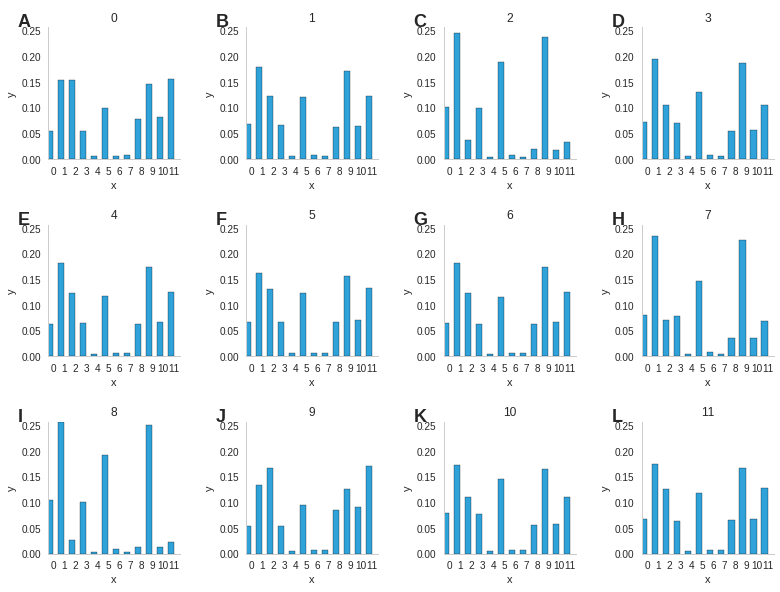

In [24]:
%%output size=70
reduce(add,graphs).cols(4)

In [53]:
tmp = model.states[0]

In [58]:
tmp.distribution.distributions[0].parameters[0]

{'dim0': 0.007462686567165304,
 'dim1': 0.007462686567166237,
 'dim2': 0.9746268656716677,
 'dim3': 0.010447761194000668}

In [87]:
model.get_params()

{'class': 'HiddenMarkovModel',
 'distribution ties': [],
 'edges': [(0, 2, 0.4259257424771954, 0.18179177873199662, None),
  (0, 0, 0.25925925925913185, 0.32765685909577097, None),
  (0, 3, 0.31481499826367265, 0.41622575934199774, None),
  (0, 1, 0.0, 0.074325602830234677, None),
  (2, 2, 0.17142862214010643, 0.068198107558105139, None),
  (2, 0, 0.40000011832689364, 0.04886945179093867, None),
  (2, 3, 0.142856889494129, 0.68853264500082401, None),
  (2, 1, 0.285714370038871, 0.19439979565013218, None),
  (4, 2, 0.0, 0.10921979371038287, None),
  (4, 0, 0.714285714285821, 0.52123872024089379, None),
  (4, 3, 0.285714285714179, 0.29796801127531053, None),
  (4, 1, 0.0, 0.071573474773412721, None),
  (3, 2, 0.21874991524356782, 0.26734717787735046, None),
  (3, 0, 0.4687498483359964, 0.45838734336651188, None),
  (3, 3, 0.18750027665129523, 0.2009783265936724, None),
  (3, 1, 0.12499995976914059, 0.073287152162465272, None),
  (1, 2, 0.0, 0.24075535881685192, None),
  (1, 0, 0.93333333